In [71]:
# Include libraries which may use in implementation
import numpy as np
import matplotlib.image as img
import random
import glob 
import pickle
import sklearn.datasets as ds
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [8]:
from google.colab import drive # import google drive as a folder to colab environment
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [9]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Imbalanced_MNIST_Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [10]:
def loadDataset(path):
    print('Loading Dataset...')
    train_x, train_y, test_x, test_y = [], [], [], []
    for i in range(10):
        for filename in glob.glob(path + '/train/' + str(i)+'/*.png'):
            im=img.imread(filename)
            train_x.append(im)
            train_y.append(i)
    for i in range(10):
        for filename in glob.glob(path + '/test/' + str(i)+'/*.png'):
            im=img.imread(filename)
            test_x.append(im)
            test_y.append(i)
    print('Dataset loaded...')
    return np.array(train_x), np.array(train_y), np.array(test_x),np.array(test_y)

In [11]:
train_set_x, train_set_y, test_set_x, test_set_y = loadDataset("/content/Imbalanced_MNIST_Dataset/Dataset")

Loading Dataset...
Dataset loaded...


In [12]:
print(train_set_x[0])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

train_set_x shape:  (43470, 28, 28)
test_set_x shape:  (10000, 28, 28)
train_set_y  shape:  (43470,)
test_set_y shape:  (10000,)


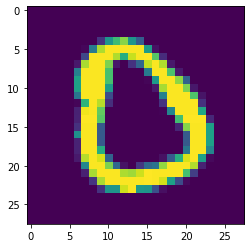

In [13]:
index = 40
plt.imshow(train_set_x[index]) 

print("train_set_x shape: ",train_set_x.shape)
print("test_set_x shape: ",test_set_x.shape)
print("train_set_y  shape: ",train_set_y .shape)
print("test_set_y shape: ",test_set_y.shape)

In [14]:
idx = np.random.permutation(len(train_set_x))
train_set_xin,train_set_yin = train_set_x[idx], train_set_y[idx]

In [15]:
train_set_x = train_set_xin[:int(train_set_xin.shape[0]*0.85),:]# training data point
train_set_y =train_set_yin[:int(train_set_yin.shape[0]*0.85)] # training lables

val_set_x = train_set_xin[int(train_set_xin.shape[0]*0.85):,:] # validation data point
val_set_y  = train_set_yin[int(train_set_yin.shape[0]*0.85):]# validation lables

In [16]:
print("train_set_x shape: ",train_set_x.shape)
print("train_set_y  shape: ",train_set_y .shape)
print("test_set_x shape: ",test_set_x.shape)
print("test_set_y shape: ",test_set_y.shape)
print("val_set_x shape",val_set_x.shape)
print("val_set_y shape",val_set_y.shape)

train_set_x shape:  (36949, 28, 28)
train_set_y  shape:  (36949,)
test_set_x shape:  (10000, 28, 28)
test_set_y shape:  (10000,)
val_set_x shape (6521, 28, 28)
val_set_y shape (6521,)


# Convert Class Labels from (10000,) to (10000, 1)

In [17]:
def to_vector(_array):
    return _array.reshape(_array.shape[0], -1);

# Convert to vector to avoid any issue during multiplication of matrices 
train_set_y = to_vector(train_set_y)
val_set_y = to_vector(val_set_y)
test_set_y = to_vector(test_set_y)

In [18]:
print("train_set_x.shape: ", train_set_x.shape)
print("val_set_x.shape: ", val_set_x.shape)
print("test_set_x.shape: ", test_set_x.shape)
print("train_set_y.shape: ", train_set_y.shape)
print("val_set_y.shape: ", val_set_y.shape)
print("test_set_y.shape: ", test_set_y.shape)

train_set_x.shape:  (36949, 28, 28)
val_set_x.shape:  (6521, 28, 28)
test_set_x.shape:  (10000, 28, 28)
train_set_y.shape:  (36949, 1)
val_set_y.shape:  (6521, 1)
test_set_y.shape:  (10000, 1)


# Convolutional Neural Network class

In [56]:
# Create a Neural_Network class
class Neural_Network(object):        

    def __init__(self, input_shape ):
        self.no_of_layers = 0
        
        self.input_feature_dimensions = input_shape[1:]
        self.last_layer_output_dimensions = self.input_feature_dimensions

        self.activationFunction = self.sigmoid
        self.activationFunctionDerivative = self.sigmoid_derivative

    def add(self, layer_type = "Hidden", no_of_neurons = 10, no_of_filters=36 , filter_size=17 ):
        self.no_of_layers += 1
        layer = self.no_of_layers
        
        desired_shape = (0, 0)

        if layer_type is "Conv2D":
            out_dimensions = self.get_conv_output_dimensions(input_shape   = self.last_layer_output_dimensions, 
                                                       no_of_filters  = no_of_filters,
                                                       filter_size   = filter_size, 
                                                       stride         = 1, 
                                                       pad            = 0)
            desired_shape = (filter_size, filter_size, no_of_filters)
            learnable = 1
            setattr(self, f"W{layer}_NoOfFilters", no_of_filters)
            setattr(self, f"W{layer}_FilterSize", filter_size)
        elif layer_type is "MaxPooling":
            out_dimensions = self.get_pooling_output_dimensions(feature_map_shape   = self.last_layer_output_dimensions,
                                                       mode           = "max",
                                                       filter_size   = filter_size,
                                                       stride         = 2)
            learnable = 0 # no parameters to learn
            setattr(self, f"W{layer}_FilterSize", filter_size)
        elif layer_type is "Flatten":
            out_dimensions = self.get_flatten_output_dimensions(self.last_layer_output_dimensions)
            learnable = 0 # no parameters to learn
        elif layer_type is "Hidden":
            desired_shape = (self.last_layer_output_dimensions + 1, no_of_neurons)
            out_dimensions = no_of_neurons
            learnable = 1
        elif layer_type is "Output":
            desired_shape = (self.last_layer_output_dimensions + 1, no_of_neurons)
            out_dimensions = no_of_neurons
            learnable = 1
        
        setattr(self, f"W{layer}_Type", layer_type)
        setattr(self, f"W{layer}_learnable", learnable)
        setattr(self, f"W{layer}_outputDimensions", out_dimensions)
        setattr(self, f"W{layer}", np.random.normal(size=desired_shape, scale=0.1))
        setattr(self, f"W{layer}_Shape", desired_shape)
        
        self.last_layer_output_dimensions = out_dimensions
            
    def summary(self):
        header = '-' * 20 + '  Summary  ' + '-' * 20
        print(header)
        for i in range(self.no_of_layers):
            layer = i+1
            
            print("Layer%d:\tType=%s,\tLearnable=%d,\tOutput=%s,\tWeights=%s" %(layer,
                                                        getattr(self, f"W{layer}_Type"),
                                                        getattr(self, f"W{layer}_learnable"),
                                                        getattr(self, f"W{layer}_outputDimensions"),
                                                        getattr(self, f"W{layer}").shape))
            
    def conv_forward(self, layer, inputs):
        
        filters = getattr(self, f"W{layer}")
        conv_out = np.zeros(((inputs.shape[0],) + getattr(self, f"W{layer}_outputDimensions")))
        number_of_elements = inputs.shape[0]
        for i in range(number_of_elements):
            conv_out[i] = self.conv_single_input(inputs[i], filters)
            
        return conv_out
    
    def conv_single_input(self, input, filters, stride = 1, pad = 0):

        # following implementation is only for pad = 0
        f = filters.shape[0]

        (input_n_h, input_n_w) = input.shape

        output_n_h = math.floor((input_n_h - f + 2 * pad) / stride + 1)
        output_n_w = math.floor((input_n_w - f + 2 * pad) / stride + 1)
        output_n_c = filters.shape[2]

        output = np.zeros((output_n_h, output_n_w, output_n_c))
        
        for c in range(output_n_c):
            for h in range(0, output_n_h, stride):
                for w in range(0, output_n_w, stride):
                    input_patch = input[w*stride:w*stride+f, h*stride:h*stride+f]
                    output[h, w, c] = np.sum(np.multiply(input_patch, filters[:,:,c]))

        return output
    
    def pool_forward(self, layer, inputs):
        filter_size = getattr(self, f"W{layer}_FilterSize")
        pool_out = np.zeros(((inputs.shape[0],) + getattr(self, f"W{layer}_outputDimensions")))
        number_of_elements = inputs.shape[0]
        for i in range(number_of_elements):
            pool_out[i] = self.pool_single_input(feature_map=inputs[i], filter_size=filter_size)
            
        return pool_out
    
    def pool_single_input(self, feature_map, mode = "max", filter_size = 2, stride = 2):

        # following implementation is only for mode = 'max'
        f = filter_size

        (input_n_h, input_n_w, input_n_c) = feature_map.shape

        output_n_h = math.floor((input_n_h - f) / stride + 1)
        output_n_w = math.floor((input_n_w - f) / stride + 1)
        output_n_c = input_n_c

        output = np.zeros((output_n_h, output_n_w, output_n_c))

        for c in range(output_n_c):
            for h in range(0, output_n_h, stride):
                for w in range(0, output_n_w, stride):
                    if mode == "max":
                        output[h, w, c] = np.amax(feature_map[w*stride:w*stride+f, h*stride:h*stride+f, c])
                    elif mode == "avg":
                        output[h, w, c] = np.mean(feature_map[w*stride:w*stride+f, h*stride:h*stride+f, c])
                    else:
                        output[h, w, c] = np.amax(feature_map[w*stride:w*stride+f, h*stride:h*stride+f, c])

        return output

    def flatten(self, layer, inputs):
        flatten_out = np.zeros((inputs.shape[0], getattr(self, f"W{layer}_outputDimensions")))
        number_of_elements = inputs.shape[0]
        for i in range(number_of_elements):
            flatten_out[i] = inputs[i].flatten()
            
        return flatten_out

    def get_flatten_output_dimensions(self, input_shape):
        output_size = 1
        for elem in range(len(input_shape)):
            output_size *= input_shape[elem]

        return output_size

    def get_pooling_output_dimensions(self, feature_map_shape, mode = "max", filter_size = 2, stride = 2):
        f = filter_size

        (input_n_h, input_n_w, input_n_c) = feature_map_shape

        output_n_h = math.floor((input_n_h - f) / stride + 1)
        output_n_w = math.floor((input_n_w - f) / stride + 1)
        output_n_c = input_n_c

        return (output_n_h, output_n_w, output_n_c)

    def get_conv_output_dimensions(self, input_shape, no_of_filters=36, filter_size=17, stride = 1, pad = 0):
        f = filter_size
        (input_n_h, input_n_w) = input_shape

        output_n_h = math.floor((input_n_h - f + 2 * pad) / stride + 1)
        output_n_w = math.floor((input_n_w - f + 2 * pad) / stride + 1)
        output_n_c = no_of_filters

        return (output_n_h, output_n_w, output_n_c)

    def to_vector(self, _array):
        return _array.reshape(_array.shape[0], -1);

    def append_ones_with_Input(self, X):
        # number of samples in the data
        N = X.shape[0]
        # append 1 (for bias)
        X = np.hstack((np.ones((N,1)), X))
        return X;
    
    def probabilities_to_y_predicted(self, probabilities):
        return self.to_vector(np.argmax(probabilities, axis=1))
    
    def weight_activation(self, _input, _weight):
        return np.dot(self.append_ones_with_Input(_input), _weight);
    
    def feedforward(self, X):
        #forward propagation through our network
        # Set input as output of layer 0. Note: there is no layer 0. it is just used to make generic code.
        setattr(self, f"Y0", X)
        for i in range(self.no_of_layers):
            layer = i+1
            if getattr(self, f"W{layer}_Type") is "Conv2D":
                # Convolution Layer
                setattr(self, f"Y{layer}", self.conv_forward(layer, X))
            if getattr(self, f"W{layer}_Type") is "MaxPooling":
                # Max Pooling Layer
                setattr(self, f"Y{layer}", 
                        self.pool_forward(layer, getattr(self, f"Y{layer-1}")))
            if getattr(self, f"W{layer}_Type") is "Flatten":
                # Flatten Layer
                setattr(self, f"Y{layer}", self.flatten(layer, getattr(self, f"Y{layer-1}")))
            if getattr(self, f"W{layer}_Type") is "Hidden":
                # Hidden Layer
                setattr(self, f"Z{layer}", self.weight_activation(getattr(self, f"Y{layer-1}"), getattr(self, f"W{layer}")))
                setattr(self, f"Y{layer}", self.activationFunction(getattr(self, f"Z{layer}")))  
            if getattr(self, f"W{layer}_Type") is "Output":
                # Output Layer
                setattr(self, f"Z{layer}", self.weight_activation(getattr(self, f"Y{layer-1}"), getattr(self, f"W{layer}")))
                setattr(self, f"Y{layer}", self.softmax(getattr(self, f"Z{layer}")))

        # Return result of feedforward (output of output layer)
        return getattr(self, f"Y{self.no_of_layers}");

    def sigmoid(self, s):
        return 1 / (1 + np.exp(-s));

    def sigmoid_derivative(self, s):
        return s * (1 - s);

    def softmax(self, x):
        all_exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return all_exps / np.sum(all_exps, axis=1, keepdims=True)
    
    def backpass_conv2D(self, layer, loss):
        
        inputs = getattr(self, f"Y{layer-1}")
        back_loss = np.zeros((getattr(self, f"W{layer}").shape))
        number_of_elements = inputs.shape[0]
        for i in range(number_of_elements):
            back_loss += self.conv_single_input(inputs[i], filters=loss[i])
            
        return back_loss
    
    def backpass_maxpooling(self, layer, loss):
        reverse_out = np.zeros(((loss.shape[0],) + getattr(self, f"W{layer-1}_outputDimensions")))
        number_of_elements = loss.shape[0]
        for i in range(number_of_elements):
            reverse_out[i] = self.pool_single_input_backprop(getattr(self, f"Y{layer-1}")[i], 
                                                        getattr(self, f"Y{layer}")[i], loss[i])
        
        return reverse_out
    
    def pool_single_input_backprop(self, in_matrix, out_matrix, loss, mode = "max", filter_size = 2, stride = 2):
        # following implementation is only for mode = 'max'
        f = filter_size    
        back_loss = np.zeros(in_matrix.shape)
        for c in range(out_matrix.shape[2]):
            for h in range(out_matrix.shape[0]):
                for w in range(out_matrix.shape[1]):
                    for h_window in range(f):
                        for w_window in range(f):
                            if out_matrix[h][w][c] == in_matrix[((h-1)*stride)+h_window][((w-1)*stride)+w_window][c]:
                                back_loss[((h-1)*stride)+h_window][((j-1)*stride)+j_slide][c] = loss[h][w][c]
        return back_loss
        
    def backpass_flatten(self, layer, loss):
        desired_shape = getattr(self, f"W{layer-1}_outputDimensions")
        reverse_out = np.zeros(((loss.shape[0],) + desired_shape))
        number_of_elements = loss.shape[0]
        for i in range(number_of_elements):
            reverse_out[i] = loss[i].reshape(desired_shape)
            
        return reverse_out
    
    def backwardpropagate(self, X, Y, y_pred, lr):
        # Computing derivatives during back propagation
        for i in reversed(range(self.no_of_layers)):
            layer = i+1
            if getattr(self, f"W{layer}_Type") is "Output":
                # Backprop for Last Layer (Output Layer) 
                setattr(self, f"dE_by_dZ{layer}", self.crossentropy_softmax_derivative(Y, y_pred))
                setattr(self, f"dE_by_dW{layer}", np.matmul(self.append_ones_with_Input(getattr(self, f"Y{layer-1}")).T, getattr(self, f"dE_by_dZ{layer}")))
            elif getattr(self, f"W{layer}_Type") is "Hidden":
                # Backprop for Hidden Layers
                setattr(self, f"dE_by_dY{layer}", np.matmul(getattr(self, f"dE_by_dZ{layer+1}"), getattr(self, f"W{layer+1}").T))
                setattr(self, f"dE_by_dY{layer}", getattr(self, f"dE_by_dY{layer}")[:,:-1])
                setattr(self, f"dY{layer}_by_dZ{layer}", self.activationFunctionDerivative(getattr(self, f"Y{layer}")))
                setattr(self, f"dE_by_dZ{layer}", getattr(self, f"dE_by_dY{layer}")*getattr(self, f"dY{layer}_by_dZ{layer}"))
                setattr(self, f"dE_by_dW{layer}", np.matmul(self.append_ones_with_Input(getattr(self, f"Y{layer-1}")).T, getattr(self, f"dE_by_dZ{layer}")))
            elif getattr(self, f"W{layer}_Type") is "Flatten":
                # Backprop for Flatten Layer
                setattr(self, f"dE_by_dY{layer}", np.matmul(getattr(self, f"dE_by_dZ{layer+1}"), getattr(self, f"W{layer+1}").T))
                setattr(self, f"dE_by_dY{layer}", getattr(self, f"dE_by_dY{layer}")[:,:-1])
                setattr(self, f"dE_by_dZ{layer}", self.backpass_flatten(layer, getattr(self, f"dE_by_dY{layer}")))
            elif getattr(self, f"W{layer}_Type") is "MaxPooling":
                # Backprop for MaxPooling Layer
                setattr(self, f"dE_by_dZ{layer}", self.backpass_maxpooling(layer, getattr(self, f"dE_by_dZ{layer+1}")))
            elif getattr(self, f"W{layer}_Type") is "Conv2D":
                # Backprop for Convolution Layer
                setattr(self, f"dE_by_dW{layer}", self.backpass_conv2D(layer, getattr(self, f"dE_by_dZ{layer+1}")))                
            
        # adjust set of weights (Updation of weights in reverse fashion)
        for i in reversed(range(self.no_of_layers)):
            layer = i+1
            type = getattr(self, f"W{layer}_Type")
            if type is not "MaxPooling" and type is not "Flatten":
#                 print(getattr(self, f"W{layer}").shape, getattr(self, f"dE_by_dW{layer}").shape)
                setattr(self, f"W{layer}", getattr(self, f"W{layer}") - lr * getattr(self, f"dE_by_dW{layer}"))
#                 print(getattr(self, f"W{layer}").shape, getattr(self, f"dE_by_dW{layer}").shape)

    def crossentropy(self, Y, Y_pred):
        # compute error based on crossentropy loss 
        # for single sample => E = − (y * log(p) + (1 − y) * log(1 − p))
        # E = – (1/N) * ∑ ci . log(pi) + (1 – ci ). log(1 – pi)
        # since log (0) is undefined. Adding small value 1e-5
        return - np.mean(Y * np.log(Y_pred + 1e-5) + (1 - Y)* np.log(1 - Y_pred + 1e-5));
    
    def crossentropy_softmax_derivative(self, Y, Y_pred):
        return (Y_pred - Y)

    def one_hot_encode(self, trainY):
        one_hot_encoded_array = np.zeros(shape=(trainY.shape[0], 10))
        
        for index_num, class_label in enumerate(trainY):
            one_hot_encoded_array[index_num, class_label] = 1
        return one_hot_encoded_array
    
    def train(self, trainX, trainY,valX, valY, epochs = 100, learningRate = 0.001, batch_size = 50):
        
        N = trainX.shape[0]
        training_accuracy = []
        training_loss = []
        validation_accuracy = []
        validation_loss = []

        # One hot encoding
        trainY_encoded = self.one_hot_encode(trainY)
        testY_encoded = self.one_hot_encode(valY)

       # backpropagation with trainX, trainY, predicted value and learning rate.

        for ep in range(epochs):
            random_indexes = np.random.permutation(N)
            loss = 0
            for _start in range(0, N, batch_size):
                mini_batch_indexes = random_indexes[_start : _start + batch_size]
                x_train = trainX[mini_batch_indexes]
                y_train = trainY_encoded[mini_batch_indexes]

                # feed forward trainX and trainY and recivce predicted value
                y_pred = self.feedforward(x_train)  
            
                # backprop and update wieghts
                self.backwardpropagate(x_train, y_train, y_pred, learningRate)
                

            #Training accuracy

            _acc = self.accuracy(trainX, trainY)
            training_accuracy.append(_acc)
            #Validation accuracy

            valid_acc = self.accuracy(valX, valY)
            validation_accuracy.append(valid_acc)
            #Training Loss

            Y_pred = self.feedforward(trainX)
            loss = self.crossentropy(Y_pred, trainY_encoded)
            training_loss.append(loss)
            #Validation Loss

            y_pred = self.feedforward(valX)
            valid_loss = self.crossentropy(y_pred, testY_encoded)
            validation_loss.append(valid_loss)

            print("Epoch = %d, accuracy = %f, error = %f"%(ep, _acc, loss))
    
        fig_size = (12, 5)
        fig, axes = plt.subplots(1, 2, figsize=fig_size)
        x = np.arange(epochs)
        axes[0].plot(x, training_accuracy, color='red', label='Training Accuracy')
        axes[0].plot(x, validation_accuracy, color='blue', label='Validation Accuracy')
        axes[0].set_title("Accuracy")
        axes[0].set_xlabel("Epochs")
        axes[0].legend()
        
        axes[1].plot(x, training_loss, color='red', label='Training Loss')
        axes[1].plot(x, validation_loss, color='blue', label='Validation Loss')
        axes[1].set_title("Error/Loss")
        axes[1].set_xlabel("Epochs")
        axes[1].legend()
        
        plt.savefig("Assignment_03_Accuracy_Error_Plots.png")
        plt.show()

    def predict(self, testX):
        # predict the value of testX
        predictions = self.feedforward(testX)
        return predictions;
    
    def accuracy(self, testX, testY):
        # convert probabilities to predicted classes
        Y_Predicted = self.probabilities_to_y_predicted(self.predict(testX))
        accuracy = np.mean(Y_Predicted == testY)
        return accuracy; # return accuracy    
        
    def save(self,name):
        # save your trained model, it is your interpretation how, which and what data you store
        # which you will use later for prediction
        with open(name, 'wb') as file:
            pickle.dump((self.W1, self.W4, self.W5), file)
        
    def load(self,name):
        # load your trained model, load exactly how you stored it.
        with open(name, 'rb') as file:
            self.W1, self.W4, self.W5 = pickle.load(file)

# For Learning rate 0.01 and Batch size 50

Epoch = 0, accuracy = 0.340000, error = 1.852209
Epoch = 1, accuracy = 0.396000, error = 1.547682
Epoch = 2, accuracy = 0.808000, error = 1.291981
Epoch = 3, accuracy = 0.768000, error = 1.037009
Epoch = 4, accuracy = 0.798000, error = 0.914713


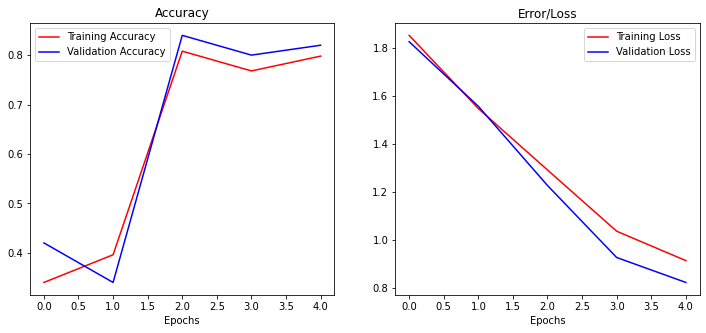

In [54]:
np.random.seed(1)

testmodel = Neural_Network(train_set_x.shape)
testmodel.add(layer_type='Conv2D', no_of_filters=36, filter_size=17)
testmodel.add(layer_type="MaxPooling", filter_size=2)
testmodel.add(layer_type="Flatten")
testmodel.add(layer_type="Hidden", no_of_neurons=128)
testmodel.add(layer_type="Output", no_of_neurons=10)

testmodel.train(train_set_x[0:500], train_set_y[0:500], val_set_x[0:50], val_set_y[0:50], epochs = 5, learningRate = 0.01, batch_size = 50)

#For Learning rate 0.1

Epoch = 0, accuracy = 0.136000, error = 1.995844
Epoch = 1, accuracy = 0.252000, error = 1.742764
Epoch = 2, accuracy = 0.240000, error = 1.810124
Epoch = 3, accuracy = 0.252000, error = 1.735796
Epoch = 4, accuracy = 0.296000, error = 1.647203


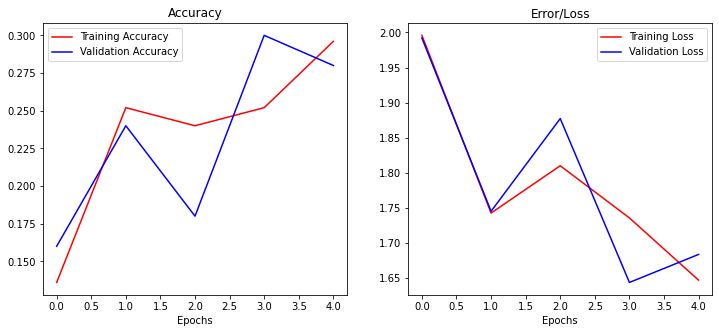

In [57]:
np.random.seed(1)

testmodel = Neural_Network(train_set_x.shape)
testmodel.add(layer_type='Conv2D', no_of_filters=36, filter_size=17)
testmodel.add(layer_type="MaxPooling", filter_size=2)
testmodel.add(layer_type="Flatten")
testmodel.add(layer_type="Hidden", no_of_neurons=128)
testmodel.add(layer_type="Output", no_of_neurons=10)

testmodel.train(train_set_x[0:500], train_set_y[0:500], val_set_x[0:50], val_set_y[0:50], epochs = 5, learningRate = 0.1, batch_size = 50)

#For Batch size 100 and Learning rate 0.01

Epoch = 0, accuracy = 0.140000, error = 1.983736
Epoch = 1, accuracy = 0.214000, error = 1.936024
Epoch = 2, accuracy = 0.240000, error = 1.770649
Epoch = 3, accuracy = 0.486000, error = 1.552246
Epoch = 4, accuracy = 0.454000, error = 1.478504


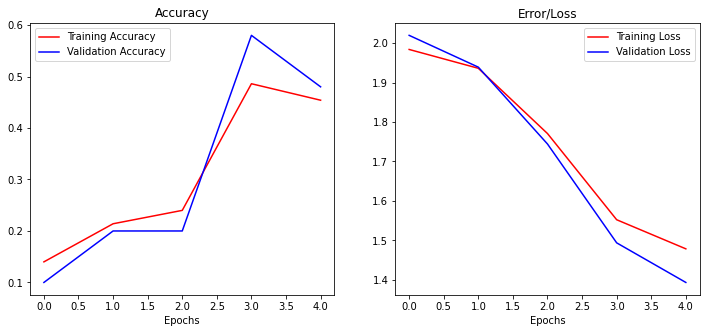

In [58]:
np.random.seed(1)

testmodel = Neural_Network(train_set_x.shape)
testmodel.add(layer_type='Conv2D', no_of_filters=36, filter_size=17)
testmodel.add(layer_type="MaxPooling", filter_size=2)
testmodel.add(layer_type="Flatten")
testmodel.add(layer_type="Hidden", no_of_neurons=128)
testmodel.add(layer_type="Output", no_of_neurons=10)

testmodel.train(train_set_x[0:500], train_set_y[0:500], val_set_x[0:50],val_set_y[0:50], epochs = 5, learningRate = 0.01, batch_size = 100)

#Training of complete dataset

In [59]:
np.random.seed(1)

model = Neural_Network(train_set_x.shape)
model.add(layer_type='Conv2D', no_of_filters=36, filter_size=17)
model.add(layer_type="MaxPooling", filter_size=2)
model.add(layer_type="Flatten")
model.add(layer_type="Hidden", no_of_neurons=128)
model.add(layer_type="Output", no_of_neurons=10)

model.summary()

--------------------  Summary  --------------------
Layer1:	Type=Conv2D,	Learnable=1,	Output=(12, 12, 36),	Weights=(17, 17, 36)
Layer2:	Type=MaxPooling,	Learnable=0,	Output=(6, 6, 36),	Weights=(0, 0)
Layer3:	Type=Flatten,	Learnable=0,	Output=1296,	Weights=(0, 0)
Layer4:	Type=Hidden,	Learnable=1,	Output=128,	Weights=(1297, 128)
Layer5:	Type=Output,	Learnable=1,	Output=10,	Weights=(129, 10)


Epoch = 0, accuracy = 0.908000, error = 0.406059
Epoch = 1, accuracy = 0.912000, error = 0.415198
Epoch = 2, accuracy = 0.915000, error = 0.381893
Epoch = 3, accuracy = 0.929000, error = 0.332283
Epoch = 4, accuracy = 0.941000, error = 0.324086


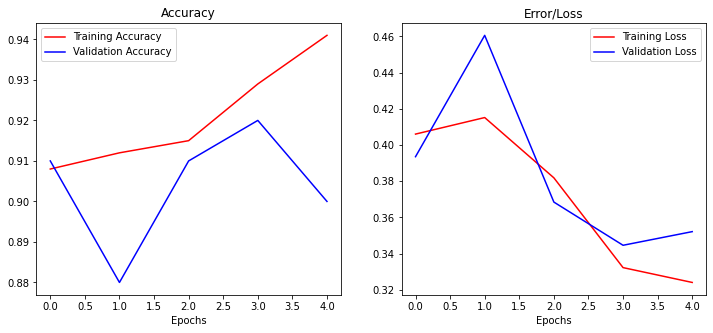

In [61]:
model.train(train_set_x[0:1000], train_set_y[0:1000] ,val_set_x[0:100], val_set_y[0:100], epochs = 5, learningRate = 0.01, batch_size = 50)

In [63]:
model.accuracy(test_set_x, test_set_y)

0.7336

In [64]:
def visualize_filters(filters):
    rows = 3 # no_of_images_in_a_row
    cols = 12 # no_of_images_in_a_column
    fig, axes = plt.subplots(rows, cols, figsize=(10, 3))

    filter_num = 0
    for i in range(rows):
        for j in range(cols):
            axes[i, j].imshow(filters[:,:,filter_num], cmap='gray')
            axes[i, j].axis('off')
            filter_num += 1

    plt.show()

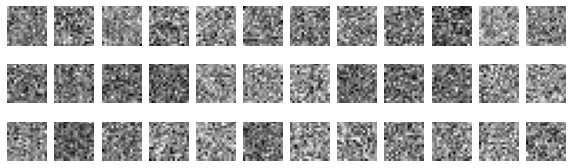

In [65]:
visualize_filters(model.W1)

Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.60      0.75       980
           1       0.96      0.98      0.97      1135
           2       0.77      0.91      0.84      1032
           3       0.80      0.93      0.86      1010
           4       1.00      0.12      0.21       982
           5       0.66      0.85      0.74       892
           6       0.71      0.95      0.82       958
           7       0.98      0.19      0.31      1028
           8       0.88      0.86      0.87       974
           9       0.44      0.93      0.59      1009

    accuracy                           0.73     10000
   macro avg       0.82      0.73      0.70     10000
weighted avg       0.82      0.73      0.70     10000



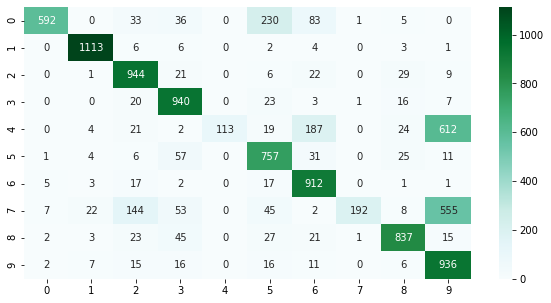

In [73]:
y_predicted = model.probabilities_to_y_predicted(model.predict(test_set_x))

print("Test Classification Report:\n", classification_report(test_set_y, y_predicted))
# heat map
fig, ax = plt.subplots(figsize=(10,5)) 
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_set_y, y_predicted))
sns.heatmap(confusion_matrix_df, annot=True, ax=ax, fmt='g', cmap='BuGn') 

plt.savefig('MNIST_Test_Confusion_Matrix.png')


In [74]:
#save the best model which you have trained, 
model.save('Mnist_Imbalanced_bestmodel.mdl')

In [75]:
print("Test Accuracy = ", model.accuracy(test_set_x, test_set_y))

Test Accuracy =  0.7336


# Full Training and Testing

In [ ]:
np.random.seed(1)

model = Neural_Network(train_set_x.shape)
model.add(layer_type='Conv2D', no_of_filters=36, filter_size=17)
model.add(layer_type="MaxPooling", filter_size=2)
model.add(layer_type="Flatten")
model.add(layer_type="Hidden", no_of_neurons=128)
model.add(layer_type="Output", no_of_neurons=10)

model.summary()

In [ ]:
model.train(train_set_x, train_set_y ,val_set_x, val_set_y, epochs = 5, learningRate = 0.01, batch_size = 50)

In [ ]:
#save the best model which you have trained, 
model.save('Mnist_Imbalanced_bestmodel.mdl')

In [ ]:
print("Test Accuracy = ", model.accuracy(test_set_x, test_set_y))

***Full Training data takes alot of time to run therefore I have added the results of random data. Kindly consider this issue.***